<a href="https://colab.research.google.com/github/Kang-Yoonah/BigAi/blob/gh-pages/3/HandsOn/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서포트 벡터 머신 SVM

- 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델
- 특히 복잡한 분류 문제에 잘 들어맞고 작거나 중간 크기의 데이터셋에 적합함.
- 구성 요소
 - boundary, hyperplane(초평면)
 - margin 마진
 - surpport vector 서포트 벡터

# 5.1 선형 SVM 분류



- 선형적으로 구분 : '결정 경계'에 의해 두 클래스가 나뉜다.
- 데이터를 잘 나누는 hyperplane(결정함수)를 찾는다.
- 2개의 클래스를 나누는데, 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있는다.   
즉, SVM 분류기는 클래스 사이에 가장 폭이 넓은 도로(Margin)를 찾는 것으로 생각할 수 있다.

**따라서 라지 마진 분류라고 한다**

- 도로 경계에 위치한 샘플을 **서포트 벡터**라고 한다.   
도로 바깥쪽에 훈련 샘플을 더 추가해도 결정 경계에 전혀 영향을 미치지 않지만,   
도로 경계에 안쪽에 위치할 시 영향을 미친다.   
즉, 도로 경계에 위치한 샘플에 의해 전적으로 결정된다.
- SVM은 특성의 스케일에 민감하다.   
    - 특성 중 하나의 스케일이 너무 크다면, 다른 특성의 성격이 무시될 수 있음. 다시 말해서, 분류하는 초평면의 역할이 약해진다.

## 5.1.1 소프트 마진 분류

- 하드 마진 분류 : 모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있을 때의 분류
 - 데이터가 선형적으로 구분될 수 있어야 제대로 작동
 - 이상치에 민감
- 소프트 마진 분류
 - 정확하게 구분되어 있지 않은 경우를 해결하기 위해서 적당한 error를 허용한다.   
 그렇다고 너무 많은 error를 허용하면 안되기 때문에, **error도 최소화하는 경계선(boundary)**를 찾아야한다.
 - 도로의 폭을 가능한 한 넓게 유지하는 것과 샘플이 도로 중간이나 반대쪽에 있는 경우인 마진 오류와의 적절한 균형을 잡는다.

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비  : 2개의 특성
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica : 2진 분류로 만든다.

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [ ]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

LinearSVC는 규제에 편향을 포함시킨다.   
그래서 훈련 세트에서 평균을 빼서 중앙에 맞추는 작업 과정이 필요하다.   
StandardScaler를 사용하여 데이터 스케일을 맞추면 자동으로 이 과정이 들어간다. 

In [ ]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [ ]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

(4.0, 5.9, 0.8, 2.8)

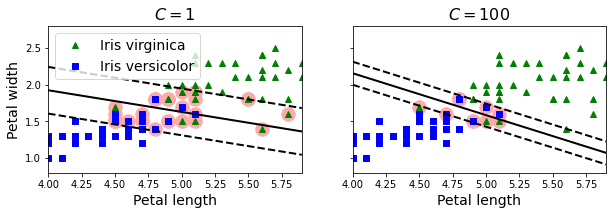

In [ ]:
import matplotlib.pyplot as plt

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])


**결과**

- C 하이퍼파라미터 조절을 통해 얻은 차이이다.
 - 낮게 설정하면 왼쪽 그림과 같고,   
 높게 설정하면 오른쪽 그림과 같은 모델을 얻는다.
 - 일반적으로 마진 오류를 적은 것을 선택하는 것이 좋지만,   
 이 경우에는 왼쪽 모델이 마진 오류는 오른쪽보다 많지만 일반화가 더 잘 될 것 같은 근거로 인해 더 좋다.
 - 즉, 하이퍼파라미터 C는 오류를 얼마나 허용할 것인지 (규제항)를 결정한다.   
 클수록 하드마진, 작을수록 소프트마진에 가까운 경향이 있다.

# 5.2 비선형 SVM 분류

선형적으로 분류할 수 없는 데이터셋도 많다.   
비선형 데이터셋을 다루는 방법을 살펴보자.

**1.다항 특성과 같은 특성을 더 추가한다.**

예시로 다음 데이터를 살펴보자.


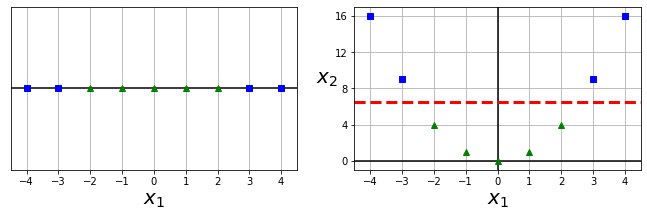

In [ ]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

결과
- 하나의 특성 X1만을 가진 왼쪽의 그래프는 선형적으로 구분되지 않는다.
- X2 특성을 추가한 오른쪽 그래프는 완벽하게 선형적으로 구분할 수 있다.   
빨간 점선이 결정경계의 예시이다.

사이킷런을 통해 구현해보자.   
PolynomialFeatures 변환기를 사용하여 다항 특성을 추가하도록 한다.   
moons 데이터셋에 적용해보자.

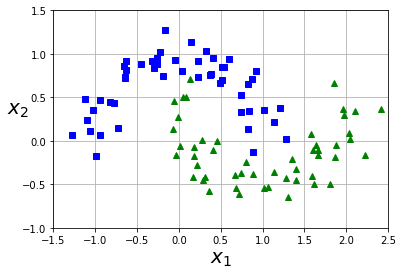

In [ ]:
# 데이터셋 plot해서 표현하기
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

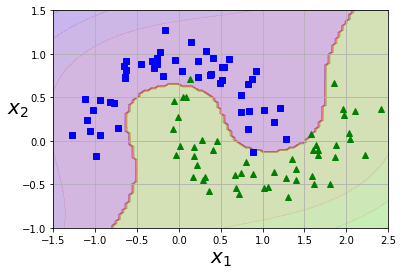

In [ ]:
# 훈련시킨 모델이 분류한 것을 그림으로 표현해보자.
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)   # 선분을 나눈다.   (구간 시작점, 구간 끝점, 구간내 숫자 개수)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]   # ravel() : 다차원 배열을 평평하게 배열
    y_pred = clf.predict(X).reshape(x0.shape)   # 1차원 배열을 shape의 행, 열 갯수에 맞춰서 reshape
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)   # contourf : 등치선 연결하기
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## 5.2.1 다항식 커널 

**다항식 특성을 추가하는 것의 문제점**
- 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못한다.   
또한 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만든다.

**2. 커널 트릭kernel trick을 사용한다.**
- 실제로 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 낸다.
- SVC 파이썬 클래스에 구현되어 있다.

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))   # degree = 3 : 3차 다항식 커널을 사용한다.
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [ ]:
# degree 10, coef0 100
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

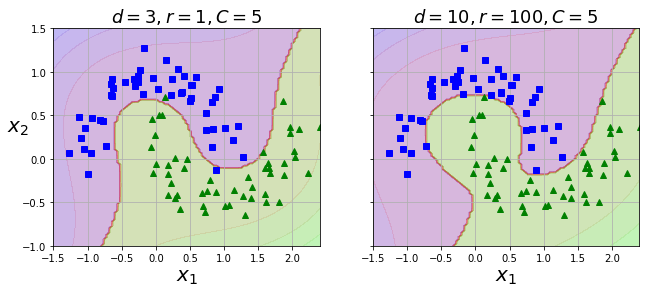

In [ ]:
# 모델 훈련 결과 살펴보기
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

**결과**
- 다항식의 차수 조절
 - 과대적합일 때, 차수를 줄인다.
 - 과소적합일 때, 차수를 늘린다.
- 매개변수 coef0
 - 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받는지 조절한다.

##5.2.2 유사도 특성

3. 유사도 함수로 계산한 특성을 추가한다.

- 각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 유사도 함수로 계산한 특성을 추가한다.
- 이때 유사도 함수로 사용하는 것은 **가우시안 방사 기저 함수(RBF)**로 정의한다.
 - 함수의 값은 0부터 1까지 변화하며 종 모양으로 나타난다.
 - 0 : 랜드마크에서 아주 멀리 떨어진 경우   
 1: 랜드마크와 같은 위치일 경우
- 랜드마크 선택하는 법
 - 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정한다.   
 이렇게 하면 차원이 매우 커지면서 변환된 훈련 세트가 선형적으로 구분될 가능성이 높아진다.
 - 단점 : n개의 특성을 가진 m개의 샘플이 m개의 특성을 가진 m개의 샘플로 변환된다.   
 즉, 훈련 세트가 매우 클 경우 동일한 크기의 아주 많은 특성이 만들어진다.

**식 5-1: 가우시안 RBF**

$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$

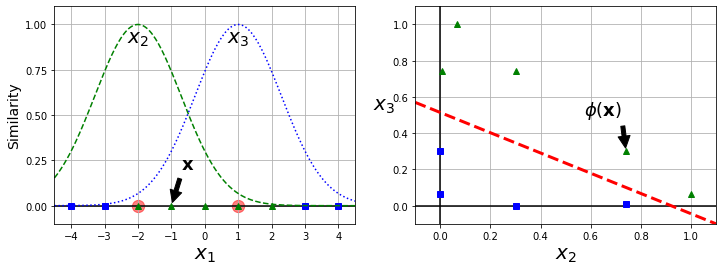

In [ ]:
# 가우시안 커널 함수와 유사도 함수를 기반으로 만든 특성 추가한 데이터 plot
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

In [ ]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


x1 = -1 샘플 살펴보기
- 첫번째 랜드마크에서 1만큼 떨어져있고   
두 번째 랜드마크에서 2만큼 떨어져있다.
- 따라서 새로 만든 특성 x2, x3의 값은 각각 0.74, 0.30이 된다.

## 5.2.3 가우시안 RBF 커널

**유사도 특성 방식 단점**
- 추가 특성을 모두 계산하려면 연산 비용이 많이 든다.

**4. 커널 트릭을 이용한 가우시안 RBF 커널 이용**
- 유사도 특성을 많이 추가하는 것과 같은 결과를 만들 수 있다.
- 일반적으로 가우시안 RBF 커널을 많이 이용한다.
- 어떤 커널은 특정 데이터 구조에 특화되어 있다.   
예를 들어, 문자열 커널인 문자열 서브시퀀스 커널, 레벤슈타인 거리 기반의 커널 등이 있다.


In [ ]:
# 가우시안 RBF 커널을 사용한 SVC 모델
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

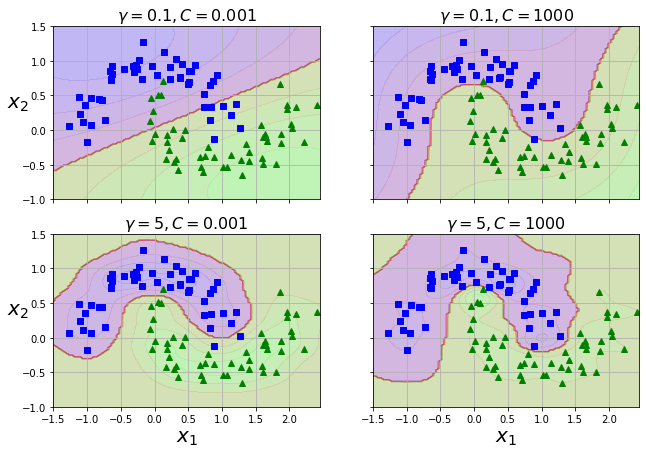

In [ ]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

결과
- 감마 5, C = 0.001 모델이 일반화가 잘 되고 적당한 모델이라 할 수 있다.
- 매개변수 gamma
 - 증가시키면 종 모양 그래프가 좁아진다.   
 즉, 각 샘플의 영향 범위가 작아진다.   
 결정 경계가 조금 더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어진다.
 - 감소시키면 종 모양 그래프가 넓어진다.   
 샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워진다. 
 - 하이퍼파라미터 gamma가 규제 역할을 한다.
 - 즉, 결정경계를 얼마나 유연하게 그릴지 결정한다.   
- 여러가지 커널 중 선형 커널을 가장 먼저 시도해봐야한다.
 - LinearSVC가 SVC(kernel = 'linear')보다 훨씬 빠르다.
 - 훈련 세트가 너무 크지 않다면 가우시안 RBF 커널이 좋다.

# 5.3 SVM 회귀

SVM 알고리즘은 다목적으로 사용할 수 있다.
- 선형, 비선형 분류 뿐만 아니라 선형, 비선형 회귀에도 사용할 수 있다.

회귀 적용 방법
- 분류와는 목표를 반대로 한다.
- SVM 회귀는 제한된 마진 오류안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 한다.
- 도로의 폭은 하이퍼파라미터 ε으로 조절한다.   
허용 오차를 설명하는 변수 ε과 헷갈리지 말자.
- 마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다.   
이를 모델이 ε에 민감하지 않다고 말한다.


회귀 알고리즘은 데이터가 주어졌을 때 데이터를 잘 설명하는 선을 찾고자 한다.   


In [ ]:
# 데이터 만들기
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [ ]:
from sklearn.svm import LinearSVR

# ε을 1.5, 0.5로 설정하여 비교해보자.
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
# 훈련
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

# 서포트벡터 찾아주는 함수
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

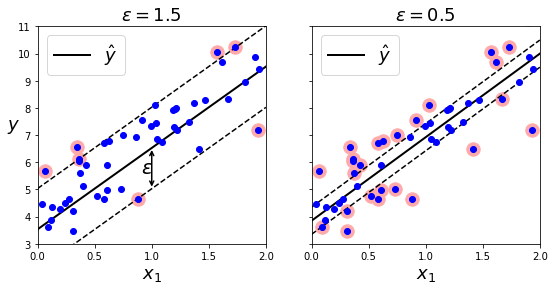

In [ ]:
# 모델 훈련 결과 예측을 그림으로 나타내어보기
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

비선형 데이터 회귀 작업
- 커널 SVM 모델을 사용한다.
- SVR은 SVC의 회귀 버전이고   
LinearSVR은 LinearSVC의 회귀 버전이다.
- LinearSVR은 필요한 시간이 훈련 세트의 크기에 비례해서 선형적으로 늘어나고   
SVR은 이에 비해 훨씬 늘어나게 된다.

In [ ]:
# 비선형 데이터 만들기
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [ ]:
# C= 100, 0.01 인 2개의 모델을 만들어 비교한다.
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

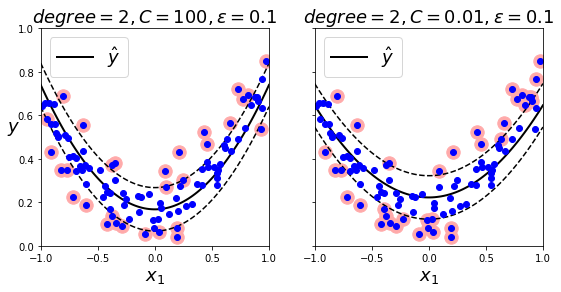

In [ ]:
# 훈련한 모델의 예측 결과를 비교해보자.
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)

plt.show()

결과
- 왼쪽 그래프는 C가 크기 때문에 규제가 거의 없다.
- 오른쪽 그래프는 C가 비교적 작기 때문에 규제가 훨씬 많다.


# 연습문제

## 9번

MNIST 데이터셋 로드

-> 훈련 세트와 테스트 세트로 나눈다.

-> 총 70,000개의 데이터를   
훈련 : 60,000개 테스트 : 10,000개로 나눈다.

In [ ]:
from sklearn.datasets import fetch_openml   # 사이킷런의 데이터셋에서 불러오기
mnist = fetch_openml('mnist_784', version=1, cache=True)    
# cache : Whether to cache the downloaded datasets into data_home

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

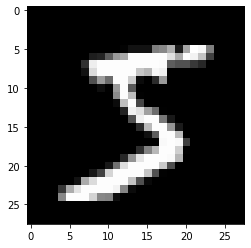

In [ ]:
one = X_train.to_numpy()[0].reshape(28,28)
plt.imshow(one, cmap='gray')
plt.show()

**minst 데이터셋**

이미 섞여있으므로 따로 섞지 않아도 된다.

**Linear SVM Classifier**

- 자동으로 OvA 또는 OvR 전략을 사용한다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8348666666666666

성능을 높이기 위해 데이터의 스케일을 조정해보자.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=42)

In [ ]:
# 스케일 조정했을 때 train에 대한 accuracy score
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9214

훨씬 나아졌지만 여전히 MNIST에서 좋은 성능은 아니다.   
 SVM을 사용한다면 커널 함수를 사용해야한다.   
 RBF 커널(기본값)로 `SVC`를 적용해보자.

In [ ]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [ ]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻어냈다.   
이제, 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝을 해보자.   
빠른 속도를 위해 작은 데이터셋으로 우선 작업한다.

**랜덤서치**

주어진 범위에서 매개변수를 무작위로 선택해 조사

n_iter 매개변수를 통해 탐색 횟수를 조정할 수 있다.

단, 샘플링이 가능한 분포를 지정해야한다.   
예를 들어, scipy.stats에 있는 uniform, randint 객체 등이 있다.   
또한 reciprocal은 로그 균등 분포 log-uniform distribution 클래스 loguniform을 제공한다.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])   # 먼저 1000개의 샘플에 대해서만 한다.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=6.769038846263591, gamma=0.009661295989662234; total time=   0.3s
[CV] END ....C=6.769038846263591, gamma=0.009661295989662234; total time=   0.3s
[CV] END ....C=6.769038846263591, gamma=0.009661295989662234; total time=   0.3s
[CV] END .....C=2.952429877980445, gamma=0.02785506848253588; total time=   0.3s
[CV] END .....C=2.952429877980445, gamma=0.02785506848253588; total time=   0.3s
[CV] END .....C=2.952429877980445, gamma=0.02785506848253588; total time=   0.3s
[CV] END .....C=3.807723624408558, gamma=0.00111848955516645; total time=   0.2s
[CV] END .....C=3.807723624408558, gamma=0.00111848955516645; total time=   0.2s
[CV] END .....C=3.807723624408558, gamma=0.00111848955516645; total time=   0.2s
[CV] END ...C=7.454722959071678, gamma=0.0022605876925380253; total time=   0.2s
[CV] END ...C=7.454722959071678, gamma=0.0022605876925380253; total time=   0.2s
[CV] END ...C=7.454722959071678, gamma=0.0022605

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3114223090>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3114223310>},
                   verbose=2)

In [ ]:
rnd_search_cv.best_estimator_

SVC(C=3.807723624408558, gamma=0.00111848955516645)

In [ ]:
rnd_search_cv.best_score_

0.8629917342492194

모든 훈련 세트에 대해 적용해보자.

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=3.807723624408558, gamma=0.00111848955516645)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9947166666666667

이제, 테스트 해보자.

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9722

## 10번

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [ ]:
a = pd.DataFrame(X)
a.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

In [ ]:
a.head(3)

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


훈련 세트와 테스트 세트로 나눕니다:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

test_size: 테스트 셋 구성의 비율을 나타낸다.   
train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해준다.   
0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미이다. default 값은 0.25.


shuffle: default=True.   
split을 해주기 이전에 섞을건지 여부. 보통은 default 값으로 놔둔다.


stratify: default=None.   
classification을 다룰 때 매우 중요한 옵션값이다.   
stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해준다. (한쪽에 쏠려서 분배되는 것을 방지)   
만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있다.


random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있다.

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)

# 훈련
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

# 서포트벡터 찾아주는 함수
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
pred1 = svm_reg1.predict(X_train)
svm_mse1 = mean_squared_error(y_train, pred1)
svm_rmse1 = np.sqrt(svm_mse1)
print(svm_rmse1)

pred2 = svm_reg2.predict(X_train)
svm_mse2 = mean_squared_error(y_train, pred2)
svm_rmse2 = np.sqrt(svm_mse2)
print(svm_rmse2)

1.0649761774277435
1.1861223665877925


In [ ]:
X_train.shape

(16512, 8)

이제 스케일 조정.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled[0]

array([-0.326196  ,  0.34849025, -0.17491646, -0.20836543,  0.76827628,
        0.05137609, -1.3728112 ,  1.27258656])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_reg = SVR()
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_reg, param_distributions, n_iter=20, verbose=2, cv=5)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...C=1.8350071669866876, gamma=0.035833879740721566; total time=  12.8s
[CV] END ...C=1.8350071669866876, gamma=0.035833879740721566; total time=   9.3s
[CV] END ...C=1.8350071669866876, gamma=0.035833879740721566; total time=   9.3s
[CV] END ...C=1.8350071669866876, gamma=0.035833879740721566; total time=   9.3s
[CV] END ...C=1.8350071669866876, gamma=0.035833879740721566; total time=   9.3s
[CV] END .....C=6.58404249735805, gamma=0.007054139087983334; total time=   9.5s
[CV] END .....C=6.58404249735805, gamma=0.007054139087983334; total time=   9.5s
[CV] END .....C=6.58404249735805, gamma=0.007054139087983334; total time=   9.5s
[CV] END .....C=6.58404249735805, gamma=0.007054139087983334; total time=   9.6s
[CV] END .....C=6.58404249735805, gamma=0.007054139087983334; total time=   9.5s
[CV] END .....C=10.06354385094736, gamma=0.00166876416291958; total time=   9.5s
[CV] END .....C=10.06354385094736, gamma=0.0016

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3114212690>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f311f6f3cd0>},
                   verbose=2)

In [ ]:
print(rnd_search_cv.best_estimator_)
print(rnd_search_cv.best_score_)

SVR(C=6.538542844013207, gamma=0.0868170593143906)
0.7469172886309391


In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, y_pred)
svm_rmse = np.sqrt(svm_mse)
print(svm_rmse)

0.5859264085045425


# 플러스 내용

## SVM 이론

### 결정 함수와 예측

**식 5-2: 선형 SVM 분류기의 예측**

$
\hat{y} = \begin{cases}
 0 & \mathbf{w}^T \mathbf{x} + b < 0 \text{ 일 때}, \\
 1 & \mathbf{w}^T \mathbf{x} + b \geq 0 \text{ 일 때}
\end{cases}
$

**<그림 5-12. iris 데이터셋의 결정 함수> 생성 코드**

In [ ]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

그림 저장: iris_3D_plot


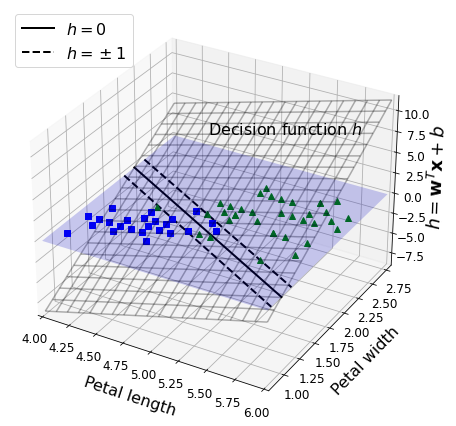

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

plt.show()

**<그림 5-13. 가중치 벡터가 작을수록 마진은 커집니다> 생성 코드**

그림 저장: small_w_large_margin_plot


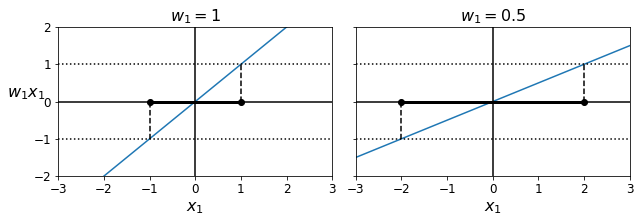

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

**식 5-3: 하드 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b}{\operatorname{minimize}}\quad{\frac{1}{2}\mathbf{w}^T \mathbf{w}} \\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

**식 5-4: 소프트 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b, \mathbf{\zeta}}{\operatorname{minimize}}\quad{\dfrac{1}{2}\mathbf{w}^T \mathbf{w} + C \sum\limits_{i=1}^m{\zeta^{(i)}}}\\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)} \quad \text{and} \quad \zeta^{(i)} \ge 0 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

**식 5-8: 2차 다항식 매핑**

$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  x_1 \\
  x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {x_1}^2 \\
  \sqrt{2} \, x_1 x_2 \\
  {x_2}^2
\end{pmatrix}
$


**식 5-9: 2차 다항식 매핑을 위한 커널 트릭**

$
\begin{split}
\phi(\mathbf{a})^T \phi(\mathbf{b}) & \quad = \begin{pmatrix}
  {a_1}^2 \\
  \sqrt{2} \, a_1 a_2 \\
  {a_2}^2
  \end{pmatrix}^T \begin{pmatrix}
  {b_1}^2 \\
  \sqrt{2} \, b_1 b_2 \\
  {b_2}^2
\end{pmatrix} = {a_1}^2 {b_1}^2 + 2 a_1 b_1 a_2 b_2 + {a_2}^2 {b_2}^2 \\
 & \quad = \left( a_1 b_1 + a_2 b_2 \right)^2 = \left( \begin{pmatrix}
  a_1 \\
  a_2
\end{pmatrix}^T \begin{pmatrix}
    b_1 \\
    b_2
  \end{pmatrix} \right)^2 = (\mathbf{a}^T \mathbf{b})^2
\end{split}
$

**식 5-10: 일반적인 커널**

$
\begin{split}
\text{선형:} & \quad K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
\text{다항식:} & \quad K(\mathbf{a}, \mathbf{b}) = \left(\gamma \mathbf{a}^T \mathbf{b} + r \right)^d \\
\text{가우시안 RBF:} & \quad K(\mathbf{a}, \mathbf{b}) = \exp({\displaystyle -\gamma \left\| \mathbf{a} - \mathbf{b} \right\|^2}) \\
\text{시그모이드:} & \quad K(\mathbf{a}, \mathbf{b}) = \tanh\left(\gamma \mathbf{a}^T \mathbf{b} + r\right)
\end{split}
$

**식 5-13: 선형 SVM 분류기의 비용 함수**

$
J(\mathbf{w}, b) = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum\limits_{i=1}^{m}max\left(0, t^{(i)} - (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)}
$

**힌지 손실 그림 생성 코드**

그림 저장: hinge_plot


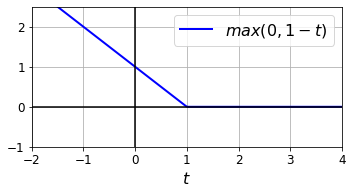

In [ ]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

## 추가 내용

## 훈련 시간

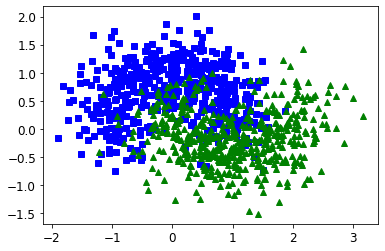

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]......................................
*.......................
*..............................................................
*...................................*.......................................................*
optimization finished, #iter = 212105
obj = -4447.997680, rho = 0.075931
nSV = 449, nBSV = 441
Total nSV = 449
0 0.1 0.7381584644317627
[LibSVM]................................................*..........................................................*..............*..............................................................*..................................................................*...........*
optimization finished, #iter = 258151
obj = -4448.479655, rho = 0.058653
nSV = 446, nBSV = 441
Total nSV = 446
1 0.01 0.7186133861541748
[LibSVM]...................................................*......*............................................................*..............................................................................*................

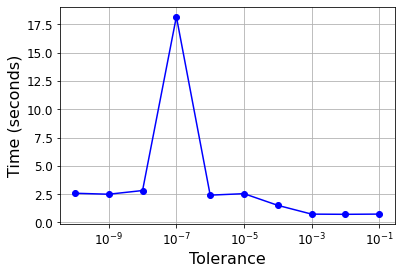

In [ ]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## 배치 경사 하강법을 사용한 선형 SVM 분류기 구현

In [ ]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [ ]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if y==0, +1 if y==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -self.C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

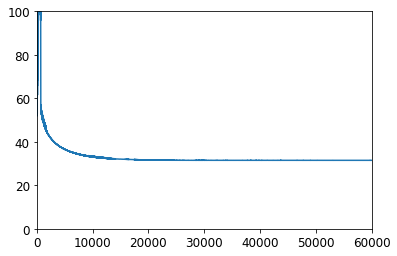

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

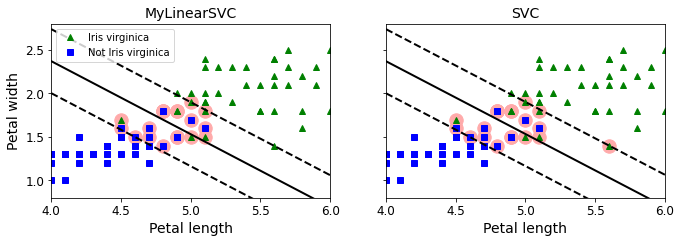

In [ ]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

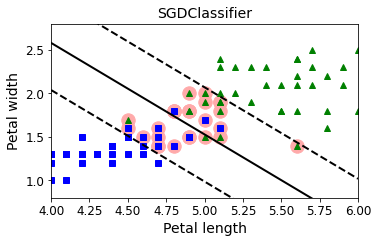

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # y==0이면 -1, y==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]  # 편향 x0=1을 추가합니다
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
